# Image Colorization with U-Net and      GAN

### 1.1- Loading Image Paths

The original paper used the entire ImageNet dataset, which contains around 1.3 million images, for training. However, you can use any large and diverse dataset for the colorization task, as long as it includes a variety of scenes and subjects. In this tutorial, I am working with a custom dataset of 15,000 historical Old Nepali images. While it is possible to load a large number of images from your dataset, you only need to select a subset (for example, 8,000 or any desired number) for training. This approach allows flexibility in dataset choice and size, depending on your available resources.

In [71]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


### 1.1.x Preparing Colab for running the code

If you are using **Google Colab**, you can install fastai by uncommenting the next cell. Most code here uses pure PyTorch; fastai is only needed for downloading datasets and one step in section two.  
Remember to set your runtime to **GPU** for faster training.

In [ ]:
# pip install fastai

This step downloads 20,000 COCO images. You can select any number of images from your dataset for training, and use other datasets like ImageNet if they have diverse scenes.


In [73]:
# from fastai.data.external import untar_data, URLs
# coco_path = untar_data(URLs.COCO_SAMPLE)
# coco_path = str(coco_path) + "/train_sample"
# use_colab = True

Here I am using my own dataset for training. Just select any number of images you want, as long as your dataset covers a variety of scenes and subjects.

In [ ]:

path = r"D:\new"

paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 15000, replace=False) # choosing 15000 images randomly
rand_idxs = np.random.permutation(15000)
train_idxs = rand_idxs[:12000] # choosing the first 12000 as training set
val_idxs = rand_idxs[12000:] # choosing last 3000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

12000 3000


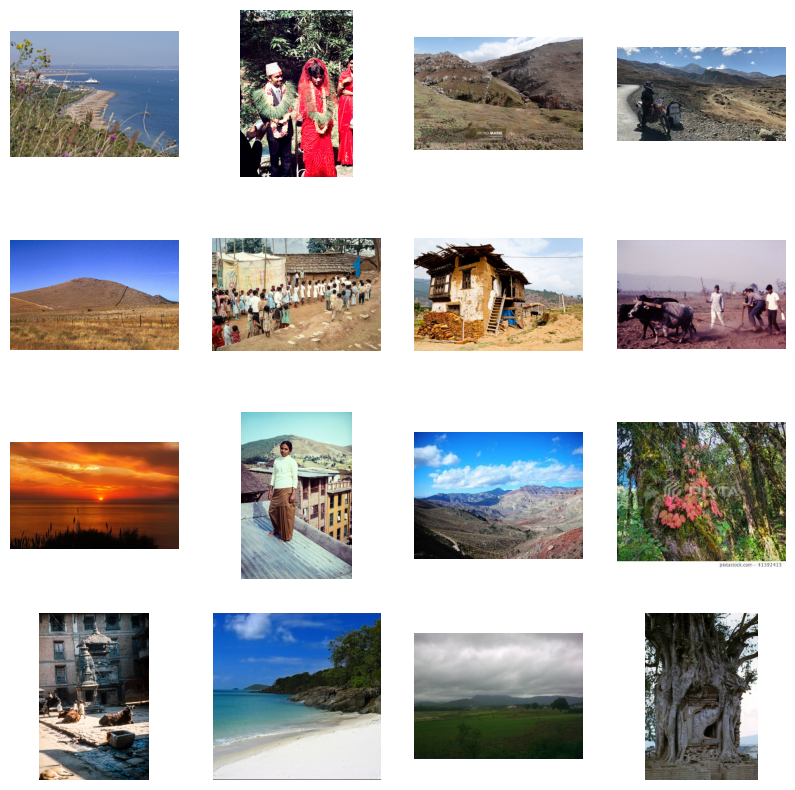

In [75]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

### 1.2- Making Datasets and DataLoaders

I'm resizing the images and flipping horizontally (flipping only if it is training set) and then I read an RGB image, convert it to Lab color space and separate the first (grayscale) channel and the color channels as my inputs and targets for the models  respectively. Then I'm making the data loaders.

In [76]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)

        self.split = split
        self.size = SIZE
        self.paths = paths

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1

        return {'L': L, 'ab': ab}

    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=8, n_workers=4, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size,
                            pin_memory=pin_memory)
    return dataloader

In [77]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

torch.Size([8, 1, 256, 256]) torch.Size([8, 2, 256, 256])
1500 375


### 1.3- Generator proposed by the paper

In [78]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)

    def forward(self, x):
        return self.model(x)

### 1.4- Discriminator

The architecture of our discriminator is rather straight forward. This code implements a model by stacking blocks of Conv-BatchNorm-LeackyReLU to decide whether the input image is fake or real. Notice that the first and last blocks do not use normalization and the last block has no activation function (it is embedded in the loss function we will use).

In [79]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

Let's take a look at its blocks:

In [80]:
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

And its output shape:

In [81]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

The Patch Discriminator outputs a grid of values (e.g., 30×30), where each value corresponds to a patch in the input image. This allows the model to judge realism at the local patch level, making it better suited for tasks like colorization.

### 1.5- GAN Loss

This class computes the GAN loss for the model. It sets up the chosen loss type (e.g., vanilla) and creates tensors for real and fake labels, then calculates the loss as needed

In [82]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

### 1.x Model Initialization

I am going to initialize the weights of the model with a mean of 0.0 and standard deviation of 0.02 which are the proposed hyperparameters.

In [83]:
def init_weights(net, init='norm', gain=0.02):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

### 1.6- Putting everything together

This class combines all components needed for training. It initializes the generator and discriminator, sets up loss functions and optimizers, and manages the training loop. The optimize method runs one training step: first updating the discriminator with real and fake images, then updating the generator using both adversarial and L1


In [84]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)

    def forward(self):
        self.fake_color = self.net_G(self.L)

    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

### 1.xx Utility functions

These are just some utility functions to log the losses of our network and also visualize the results during training. So here you can check them out:

In [87]:
### Utility functions to test results too
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """

    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")
        
def create_lab_tensors(image):
    """
    This function receives an image path or a direct image input and creates a dictionary of L and ab tensors.
    Args:
    - image: either a path to the image file or a direct image input.
    Returns:
    - lab_dict: dictionary containing the L and ab tensors.
    """
    if isinstance(image, str):
        # Open the image and convert it to RGB format
        img = Image.open(image).convert("RGB")
    else:
        img = image.convert("RGB")

    custom_transforms = transforms.Compose(
        [
            transforms.Resize((SIZE, SIZE), Image.BICUBIC),
            transforms.RandomHorizontalFlip(),  # A little data augmentation!
        ]
    )
    img = custom_transforms(img)
    img = np.array(img)
    img_lab = rgb2lab(img).astype("float32")  # Converting RGB to L*a*b
    img_lab = transforms.ToTensor()(img_lab)
    L = img_lab[[0], ...] / 50.0 - 1.0  # Between -1 and 1
    L = L.unsqueeze(0)
    ab = img_lab[[1, 2], ...] / 110.0  # Between -1 and 1
    return {"L": L, "ab": ab}


def predict_and_visualize_single_image(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    fake_color = model.fake_color.detach()
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(L[0][0].cpu(), cmap="gray")
    axs[0].set_title("Grey Image")
    axs[0].axis("off")

    axs[1].imshow(fake_imgs[0])
    axs[1].set_title("Colored Image")
    axs[1].axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")


def predict_color(model, image, save=False):
    """
    This function receives an image path or a direct image input and creates a dictionary of L and ab tensors.
    Args:
    - model : Pytorch Gray Scale to Colorization Model
    - image: either a path to the image file or a direct image input.
    """
    data = create_lab_tensors(image)
    predict_and_visualize_single_image(model, data, save)


def predict_and_return_image(image):
    data = create_lab_tensors(image)
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    fake_color = model.fake_color.detach()
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    return fake_imgs[0]


TRAIN FUNCTION TO DISPLAY TEST RESULTS

In [88]:
# TRAIN fUNCTION which can save the test result
model_path ='D:/Image_colorization/saved_models'
def save_model(model,file_path):
    torch.save(model.state_dict(), file_path)
    
def load_model(model_class, file_path):
    model = model_class()
    model.load_state_dict(torch.load(file_path))
    return model

model initialized with norm initialization
model initialized with norm initialization


100%|█████████▉| 1499/1500 [07:39<00:00,  3.51it/s]


Epoch 1/2
Iteration 1500/1500
loss_D_fake: 0.53499
loss_D_real: 0.57255
loss_D: 0.55377
loss_G_GAN: 1.25605
loss_G_L1: 9.65332
loss_G: 10.90937


C:\Users\User\AppData\Local\Temp\ipykernel_13700\3542776081.py:44: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
C:\Users\User\AppData\Local\Temp\ipykernel_13700\3542776081.py:44: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 25 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
C:\Users\User\AppData\Local\Temp\ipykernel_13700\3542776081.py:44: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 106 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
C:\Users\User\AppData\Local\Temp\ipykernel_13700\3542776081.py:44: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 65 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)


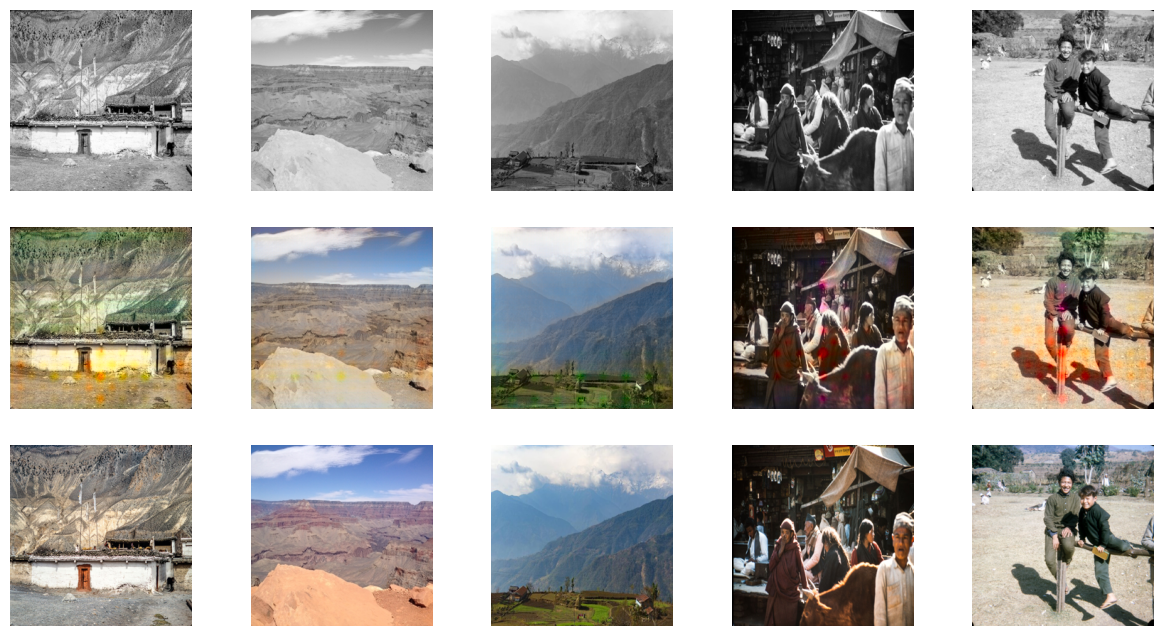

100%|██████████| 1500/1500 [07:40<00:00,  3.26it/s]


Model saved after epoch 1 at model_checkpoints\model_checkpoint_epoch_1.pth


100%|█████████▉| 1499/1500 [07:40<00:00,  3.53it/s]


Epoch 2/2
Iteration 1500/1500
loss_D_fake: 0.51363
loss_D_real: 0.57975
loss_D: 0.54669
loss_G_GAN: 1.25653
loss_G_L1: 9.79507
loss_G: 11.05160


C:\Users\User\AppData\Local\Temp\ipykernel_13700\3542776081.py:44: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 271 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
C:\Users\User\AppData\Local\Temp\ipykernel_13700\3542776081.py:44: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 164 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
C:\Users\User\AppData\Local\Temp\ipykernel_13700\3542776081.py:44: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 45 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)


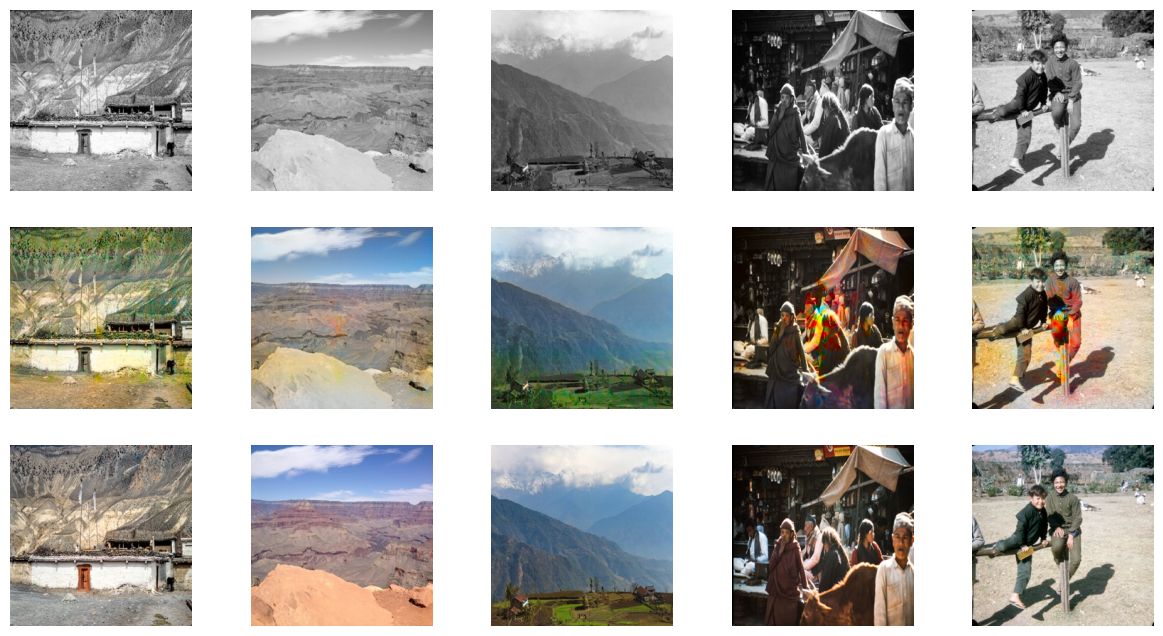

100%|██████████| 1500/1500 [07:41<00:00,  3.25it/s]


Model saved after epoch 2 at model_checkpoints\model_checkpoint_epoch_2.pth
Final model saved at model_checkpoints\model_final.pth


In [ ]:
#Train function to save checkpoint and final model
import torch
import os
from tqdm import tqdm

def train_model(model, train_dl, val_dl, epochs, display_every=1500, save_dir="model_checkpoints"):
    # Create the directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Getting a batch for visualizing the model output after fixed intervals
    data = next(iter(val_dl))
    for e in range(epochs):
        loss_meter_dict = create_loss_meters()  # function returning a dictionary of objects to
        i = 0                                   # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data)
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0))  # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict)  # function to print out the losses
                visualize(model, data, save=False)  # function displaying the model's outputs

        # Save the model after every epoch
        save_path = os.path.join(save_dir, f"model_checkpoint_epoch_{e+1}.pth")
        torch.save(model.state_dict(), save_path)
        print(f"Model saved after epoch {e+1} at {save_path}")

    # Optionally, save the final trained model
    final_save_path = os.path.join(save_dir, "model_final.pth")
    torch.save(model.state_dict(), final_save_path)
    print(f"Final model saved at {final_save_path}")

model = MainModel()
train_model(model, train_dl, val_dl, 2)


The baseline model shows basic colorization for common objects but struggles with rare cases and produces artifacts. Results are limited by dataset size and diversity, so a new approach is needed for better

## 2- Improved Training Approach

To address previous limitations, the generator is first pretrained in a supervised way. This involves two steps: using a pretrained ResNet18 as the U-Net backbone, and training the generator with L1 loss on the colorization task. After pretraining, adversarial loss is added for further improvement.

### 2.1- Generator Architecture

A U-Net with a ResNet18 backbone is built using fastai's DynamicUnet module for efficient colorization. Make sure fastai v2.4 is installed for compatibility.  

In [21]:
# pip install fastai==2.4
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

In [22]:
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18(), pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

With a few lines, you can build a U-Net using a pretrained ResNet18 backbone. The last layers for classification are removed, and DynamicUnet configures the model for colorization with 2 output channels and 256×256 input size.

### 2.2 Pretraining the generator for colorization task

In [23]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_meter.update(loss.item(), L.size(0))

        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

net_G = build_res_unet(n_input=1, n_output=2, size=256)
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()
pretrain_generator(net_G, train_dl, opt, criterion, 20)
torch.save(net_G.state_dict(), "res18-unet.pt")

  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 1/20
L1 Loss: 0.08426


  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 2/20
L1 Loss: 0.08047


  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 3/20
L1 Loss: 0.07952


  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 4/20
L1 Loss: 0.07886


  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 5/20
L1 Loss: 0.07828


  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 6/20
L1 Loss: 0.07779


  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 7/20
L1 Loss: 0.07740


  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 8/20
L1 Loss: 0.07681


  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 9/20
L1 Loss: 0.07635


  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 10/20
L1 Loss: 0.07598


  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 11/20
L1 Loss: 0.07565


  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 12/20
L1 Loss: 0.07482


  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 13/20
L1 Loss: 0.07440


  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 14/20
L1 Loss: 0.07376


  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 15/20
L1 Loss: 0.07319


  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 16/20
L1 Loss: 0.07241


  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 17/20
L1 Loss: 0.07166


  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 18/20
L1 Loss: 0.07094


  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 19/20
L1 Loss: 0.07018


  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 20/20
L1 Loss: 0.06927


With this simple function, we pretrain the generator for 20 epochs and then we save its weights. We will use this model as the generator for our GAN and train the whole network as before:

model initialized with norm initialization


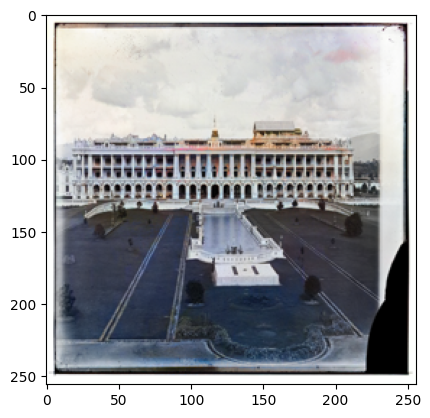

In [ ]:
import PIL
import torch
from matplotlib import pyplot as plt
from torchvision import transforms
if __name__ == '__main__':
    # Initialize your MainModel
    model = MainModel(net_G=net_G)

    # Load model weights
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.load_state_dict(torch.load(r"D:\Image_colorization\model_checkpoints\model_final.pth", map_location=device))
    resnet_weights = torch.load(r"D:\Image_colorization\res18-unet.pt", map_location=device) # (which is a ResNet-18 based model)
    resnet_state_dict = resnet_weights['state_dict'] if 'state_dict' in resnet_weights else resnet_weights

    # Update model's state dictionary with ResNet-18 weights
    model_dict = model.state_dict()
    filtered_resnet_state_dict = {k: v for k, v in resnet_state_dict.items() if k in model_dict}
    model_dict.update(filtered_resnet_state_dict)
    model.load_state_dict(model_dict)
    
    
    
    path = r"D:\Image_colorization\4 (15) - Copy.jpg"
    img = PIL.Image.open(path)
    img = img.resize((256, 256))
    # to make it between -1 and 1
    img = transforms.ToTensor()(img)[:1] * 2. - 1.
    model.eval()
    with torch.no_grad():
        preds = model.net_G(img.unsqueeze(0).to(device))
    colorized = lab_to_rgb(img.unsqueeze(0), preds.cpu())[0]
    plt.imshow(colorized)


model initialized with norm initialization
model initialized with norm initialization


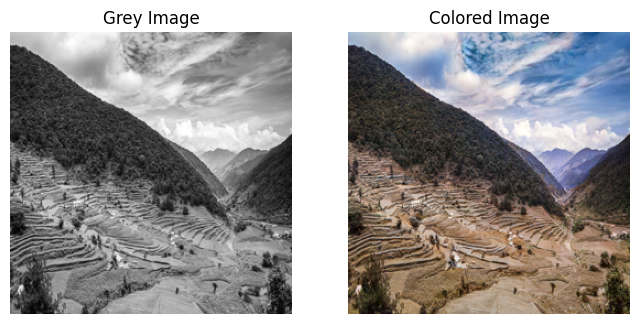

In [101]:
model1 = load_model(model_class=MainModel, file_path=r'D:\Image_colorization\model_200.pth')
predict_color(model1, image = r"D:\Image_colorization\scenry2.jpg")

### 2.3 Putting everything together, again!

The following code first loads the saved weights for the generator (from the previous section), then uses this generator in the `MainModel` class. This prevents random initialization of the generator and allows you to continue training from the pretrained state. Training for 10 to 20 epochs is usually sufficient.

This approach helps the model converge faster and achieve better results with fewer epochs.

In [ ]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("res18-unet.pt", map_location=device))
model = MainModel(net_G=net_G)
train_model(model, train_dl,val_dl, 300, display_every=1500, save_dir="model_checkpoints")

## An accidental finding: You can safely remove Dropout!

Remember that when I was explaining the theory of conditional GAN in the beginning of this article, I said that the source of the noise in the architecture of the generator proposed by authors of the paper was the dropout layers. However, when I investigated the U-Net we built with the help of fastai, I did not find any dropout layers in there! Actually I first trained the final model and got the results and then I investigated the generator and found this out.

So, was the adversarial training useless? If there is no noise, how possibly the generator can have a creative effect on the output? Is it possible that the input grayscale image to the generator plays the role of noise as well? These were my exact questions at the time.

Therefor, I decided to email Dr. Phillip Isola, the first author of the same paper we implemented here, and he kindly answered these questions. According to what he said,  this conditional GAN can still work without dropout but the outputs will be more deterministic because of the lack of that noise; however, there is still enough information in that input grayscale image which enables the generator to produce compelling outputs.
Actually, I saw this in practice that the adversarial training was helpful indeed. In the next and last section, I'm going to compare the results of the pretrained U-Net with no adversarial training against the final outputs we got with adversarial training.

## Comparing the results of the pretrained U-Net with and without adversarial training

## Final words

This project was full of important lessons for myself. I spent a lot of time during the last month to implement lots of different papers each with different strategies and it took quite a while and after A LOT of failures that I could come up with this method of training. Now you can see that how pretraining the generator significantly helped the model and improved the results.

I also learned that some observations, although at first feeling like a bad mistake of yours, are worth paying attention to and further investigation; like the case of dropout in this project. Thanks to the helpful community of deep learning and AI, you can easily ask experts and get the answer you need and become more confidant in what you were just guessing.

I want to thank the authors of this wonderful paper for their awesome work and also [the great GitHub repository of this paper](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) from which I borrowed some of the codes (with modification and simplification). I truly love the community of computer science and AI and all their hard work to improve the field and also make their contributions available to all. I'm happy to be a tiny part of this community.